## Linear Kalman Filter

This is used to estimate the dynamic state of a system from a series of noisy measurements. Copes with systems that change with time. Can also be used for future predictions as well as control systems.

The linear filter assumes that the underlying dynamics is governed by linear equations and that the measurement and process noise are gaussian.

The following code is based on an assignment I completed as part of the Fundamentals of Predictive Modelling module of MSc.


Consider damped oscillator: $$\ddot{q}(t) +\gamma\dot{q}(t) + \omega^{2}q(t) = 0$$

Reformulates to linear ODE $$\dot{x} = \underline{\underline{A}}x$$

Where $$\underline{\underline{A}} = \begin{bmatrix} 0 & 1 \\ -\omega^{2} & -\gamma \end{bmatrix} \text{and } x = \begin{pmatrix} q\\ \dot{q} \end{pmatrix}$$

Here I have implemented a Linear Kalman Filter using incorrectly centered and agnostic initial state estimate $\hat{m}(0) = (0, 0)$ and $\hat{C}(0) = 10\underline{\underline{I}}$ but with correct values of $\gamma = 0.2, \omega = 1.0$.

This is done in two steps: prediction of m and C values and then update of m and C matrices.

Prediction is done using the implicit euler numerical method (but this can be easily changed) $$ \bar{x}_{j+1} = [\underline{\underline{I}}-\tau\underline{\underline{A}}]^{-1}\bar{x}_{j}$$
$$\hat{C}_{j+1} = [\underline{\underline{I}}-\tau\underline{\underline{A}}]^{-1}\hat{C}_{j}([\underline{\underline{I}}-\tau\underline{\underline{A}}]^{-1})^{T} + 2\tau Q$$
The predicted covariance is used to calculate the Kalman gain matrix through $$ {K} = \hat{C}{H}^{T}(R + {H}\hat{C}{H}^{T})^{-1}$$
Where R is given by the standard deviation of the measuremnt noise squared and Q is the process noise.

This is then used for the update phase when measurements are taken. The mean and covariance matrices are updated through:
$$\bar{x}_{new} = \bar{x} - K(H\bar{x}-y_{obs}(t))$$
$$\hat{C}_{new} = \hat{C} - KH\hat{C}$$

In [22]:
import numpy as np
from kalman_filter import kalman_predict, kalman_gain, kalman_update
from numerical_methods import ImplicitEuler


# setting actual initial conditions
gamma = 0.2
omega = 1.0 #was 1.0
step_size = 0.01
time = 5 #s
A = np.array([[0, 1], [-(omega**2), -gamma]])
x0 = np.array([1, 2])

#first we calculate the true solution with which to compare the kalman filter with, and to obtain measurements
X_true = ImplicitEuler(x0, time, step_size, A)

H = np.array([[1, 0]]) #measurement noise only on the position

def get_noisy_measurements(x, H, measurement_freq, set_seed=None):
    if set_seed:
        np.random.seed(set_seed)
    
    noise = np.random.normal(0, 1, len(x[0, :]))
    obs = []
    for i in range(len(x[0, :])):
        if i % measurement_freq == 0:
            obs.append(H@x[:, i] + noise[i//measurement_freq]) #ensuring noise applied at appropriate indices
    return obs

#obtaining noisy observations every 10 steps
observation_frequency = 10
observations = get_noisy_measurements(X_true, H, observation_frequency)


#setting initial conditions of filter
initial_m = np.array([0, 0])
initial_C = 10 * np.identity(2)
Q = np.array([[0,0], [0,0]]) #no process noise 
R = np.array([[1]]) #std of noise squared



def linear_kalman_filter(initial_m, initial_C, A, Q, time, step_size, H, R, observations):
    num_steps = int(time/step_size)

    m_estimates = np.empty((num_steps, 2))
    C_estimates = np.empty((num_steps, 2, 2))

    m_estimates[0] = initial_m
    C_estimates[0] = initial_C

    KF_counter = 0

    for i in range(1, num_steps):#from range 1 as already have initial values
        predicted_m, predicted_cov = kalman_predict(m_estimates[i-1], C_estimates[i-1], A, Q, step_size)
        if KF_counter > 0 and KF_counter % 10 == 0: #measurments occur every 10 timesteps
            gain = kalman_gain(predicted_cov, H, R)
            m_estimates[i], C_estimates[i] = kalman_update(predicted_m, gain, predicted_cov, H, observations[i//10])
        else: #if not measurement just append predicted value
            m_estimates[i] = predicted_m
            C_estimates[i] = predicted_cov
        KF_counter += 1

    position_std_dev = np.zeros(len(m_estimates))
    velocity_std_dev = np.zeros(len(m_estimates))
    for i in range(len(C_estimates)): # calculating std from covariance matrices
        position_std_dev[i] = (np.sqrt(C_estimates[i, 0, 0]))
        velocity_std_dev[i] = (np.sqrt(C_estimates[i, 1, 1]))
        
    return m_estimates, position_std_dev, velocity_std_dev

state_estimates, pos_errors, vel_errors = linear_kalman_filter(initial_m, initial_C, A, Q, time, step_size, H, R, observations)


Text(0.5, 0.98, 'Linear Kalman Filter')

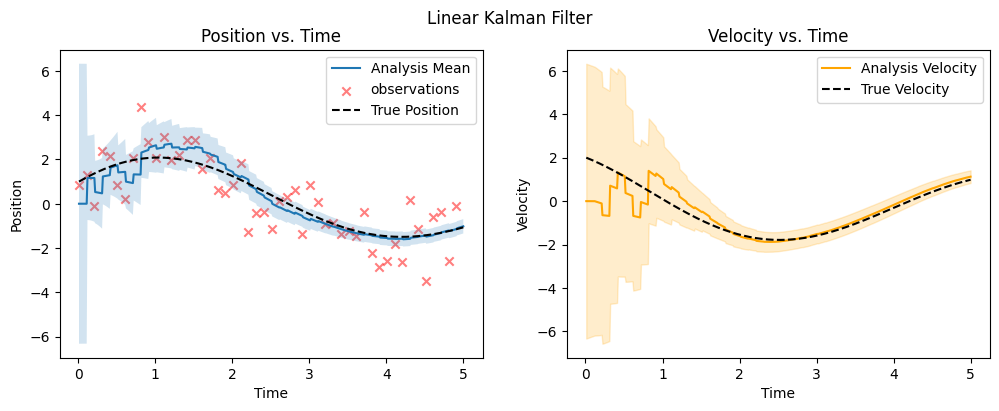

In [23]:
import matplotlib.pyplot as plt

N_std_dev = 2 #chose number of standard devs to fill between (accepted range)

fig2, (ax5, ax6) = plt.subplots(1, 2, sharex=True, figsize = ((12, 4)))

time_array = np.arange(0.01, time+step_size, step_size)

#plotting positions estimates and errors
ax5.plot(time_array, state_estimates[:,0] , label="Analysis Mean")
ax5.scatter(time_array[::observation_frequency], observations, marker = 'x', color ='red', label = 'observations', alpha = 0.5)
ax5.plot(time_array, X_true[0, :],'--', color = 'black', label = 'True Position')
ax5.set_ylabel("Position")
ax5.set_xlabel("Time")
ax5.set_title("Position vs. Time")
ax5.fill_between(time_array, state_estimates[:,0] + N_std_dev*pos_errors, state_estimates[:,0]- N_std_dev*pos_errors, alpha = 0.2) # gives accepted range
ax5.legend()

#plotting velocity estimates and errors
ax6.plot(time_array, state_estimates[:,1], label="Analysis Velocity", color="orange")
ax6.plot(time_array, X_true[1, :], '--', color = 'black', label = 'True Velocity')
ax6.set_xlabel("Time")
ax6.set_ylabel("Velocity")
ax6.set_title("Velocity vs. Time")
ax6.fill_between(time_array, state_estimates[:,1] + N_std_dev*vel_errors, state_estimates[:,1] - N_std_dev*vel_errors, alpha = 0.2, color = 'orange')
ax6.legend()

fig2.suptitle("Linear Kalman Filter")

To make estimations of parameters $\omega$ and $\gamma$ you would need to include these parameters and how they vary with time into the state vector, these relationships maybe non-linear therefor the linear kalman filter may not be appropriate. Instead the extended kalman filter could be used for example.